Matplotlib Reference:<br>https://matplotlib.org/stable/gallery/statistics/multiple_histograms_side_by_side.html#sphx-glr-gallery-statistics-multiple-histograms-side-by-side-py

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
csv_drought = 'data/droughts/wsh_p40_droughts.csv'
csv_ba_table = 'data/EIA930_Reference_Tables.csv'
col_region = 'Region/Country Name'
region_order = ['California', 'Northwest', 'Southwest', 'Central', 'Midwest', 'Texas', 'New England', 'New York', 'Mid-Atlantic', 'Tennessee', 'Carolinas', 'Southeast', 'Florida']
region_map = {'California': 'Western', 'Northwest': 'Western', 'Southwest': 'Western', 'Central': 'Eastern', 'Midwest': 'Eastern', 'Texas': 'Texas', 'New England': 'Eastern', 'New York': 'Eastern', 'Mid-Atlantic': 'Eastern', 'Tennessee': 'Eastern', 'Carolinas': 'Eastern', 'Southeast': 'Eastern', 'Florida': 'Eastern'}

csv_ba_center = 'data/ba-centroids-rev.csv'
csv_data_ws = 'data/ba_solar_wind_load_monthly_1980_2019.csv'
csv_data_h = 'data/godeeep-hydro-historical-monthly.csv'
csv_data_h_meta = 'data/godeeep-hydro-plants.csv'

# check reference datasets
df_ba_center = pd.read_csv(csv_ba_center, index_col = 0)
df_data_ws = pd.read_csv(csv_data_ws)
data_h_meta = pd.read_csv(csv_data_h_meta).set_index('eia_id').drop('plant', axis=1)
df_data_h = pd.read_csv(csv_data_h, parse_dates = ['datetime']).set_index('eia_id').join(data_h_meta, how='left')


In [11]:
# identify BAs not qualified (missing either electricity source)
df_data_ws = df_data_ws[np.isfinite(df_data_ws['solar_num_sites']) & np.isfinite(df_data_ws['wind_num_sites'])]
ba_wsh = np.intersect1d(df_data_ws['ba'].unique().astype(str), df_data_h['ba'].unique().astype(str))
ba_x = np.setdiff1d(df_ba_center.index, ba_wsh)
#print(f'BAs with all electricity sources: {ba_wsh}')
#print(f'BAs missing either electricity source: {ba_x}')
#print(f'BAs with no location: {np.setdiff1d(ba_wsh, df_ba_center.index)}')

# read a drought dataset
df_drought = pd.read_csv(csv_drought)
df_drought.index = pd.to_datetime(df_drought['datetime_utc']) # set datetime as an index
df_drought = df_drought.drop(columns = 'datetime_utc')

# read EIA930 for region information and merge
df_ba_table = pd.read_csv(csv_ba_table, index_col = 0)
df_ba_table['Interconnection'] = df_ba_table[col_region].map(region_map)
df_drought = df_drought.merge(df_ba_table, how = 'inner', left_on = 'ba', right_index = True)
#print(df_ba_table.loc[ba_wsh, col_region].groupby(by = df_ba_table.loc[ba_wsh, col_region]).count())

# expand energy drought events by duration
# comment out if double-counting one single event
for idx, df in df_drought.copy().iterrows():
    for i in range(1, df['drought_duration']):
        df_iter = df_drought.loc[df_drought['ba'] == df['ba']].loc[[idx], :]
        df_iter.index = pd.DatetimeIndex([idx + pd.offsets.MonthBegin(i)], name = 'datetime_utc')
        df_drought = pd.concat([df_drought, df_iter])
df_drought = df_drought.sort_values(['ba', 'drought_id'])

# select columns of interest
#col_sort = []
#for r in region_order:
#    col_sort = col_sort + df_drought.loc[df_drought[col_region] == r, 'ba'].unique().tolist()
#col_sort = ['PSEI', 'BPAT', 'PGE', 'PACW', 'CISO', 'LDWP', 'AVA', 'IPCO', 'NEVP', 'WALC', 'SRP', 'NWMT', 'PACE', 'WACM', 'PSCO', 'SWPP', 'SPA', 'AECI', 'ERCO', 'MISO', 'TVA', 'PJM', 'NYIS', 'ISNE']
col_sort = ['BPAT', 'PACW', 'PGE', 'PSEI', 'CISO', 'LDWP', 'AVA', 'IPCO', 'NEVP', 'SRP', 'WALC', 'NWMT', 'PACE', 'PSCO', 'WACM', 'ERCO', 'AECI', 'MISO', 'SPA', 'SWPP', 'TVA', 'ISNE', 'NYIS', 'PJM']

# extract histogram bins
bin_height = 1 # year: integer, month: float
binned_dataset_spring = []
binned_dataset_summer = []
binned_dataset_fall = []
binned_dataset_winter = []
df_drought_offset = df_drought.copy()
df_drought_offset.index = df_drought.index + pd.to_timedelta(df_drought.index.days_in_month, unit = 'D')
for c in col_sort:
    # count BA energy drought events seasonaly
    ba_bin = df_drought_offset.loc[(df_drought_offset['ba'] == c) & (df_drought_offset.index.month.isin([1, 2, 3])), 'ba']
    ba_bin = ba_bin.groupby(ba_bin.index.year).count()
    ba_bin = ba_bin.reindex(np.arange(df_drought.index.min().year, df_drought.index.max().year + 1, bin_height), fill_value = 0, method = 'nearest', tolerance = 0.5 * bin_height)
    binned_dataset_winter.append(ba_bin.to_numpy())

    ba_bin = df_drought_offset.loc[(df_drought_offset['ba'] == c) & (df_drought_offset.index.month.isin([4, 5, 6])), 'ba']
    ba_bin = ba_bin.groupby(ba_bin.index.year).count()
    ba_bin = ba_bin.reindex(np.arange(df_drought.index.min().year, df_drought.index.max().year + 1, bin_height), fill_value = 0, method = 'nearest', tolerance = 0.5 * bin_height)
    binned_dataset_spring.append(ba_bin.to_numpy())

    ba_bin = df_drought_offset.loc[(df_drought_offset['ba'] == c) & (df_drought_offset.index.month.isin([7, 8, 9])), 'ba']
    ba_bin = ba_bin.groupby(ba_bin.index.year).count()
    ba_bin = ba_bin.reindex(np.arange(df_drought.index.min().year, df_drought.index.max().year + 1, bin_height), fill_value = 0, method = 'nearest', tolerance = 0.5 * bin_height)
    binned_dataset_summer.append(ba_bin.to_numpy())

    ba_bin = df_drought_offset.loc[(df_drought_offset['ba'] == c) & (df_drought_offset.index.month.isin([10, 11, 12])), 'ba']
    ba_bin = ba_bin.groupby(ba_bin.index.year).count()
    ba_bin = ba_bin.reindex(np.arange(df_drought.index.min().year, df_drought.index.max().year + 1, bin_height), fill_value = 0, method = 'nearest', tolerance = 0.5 * bin_height)
    binned_dataset_fall.append(ba_bin.to_numpy())

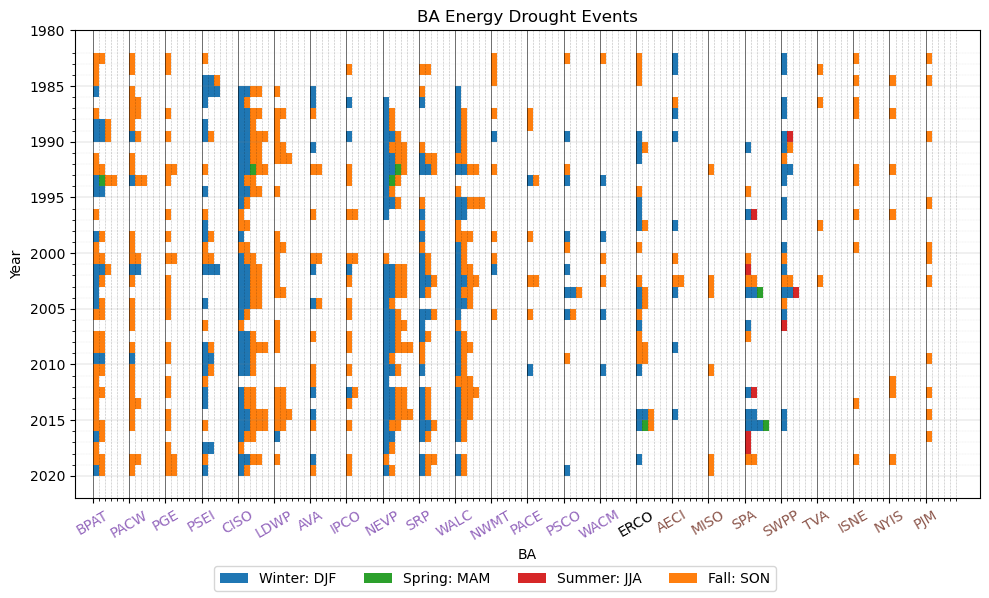

In [12]:
# set x locations (region) based on the maximum
binned_max = 6
x_locations = np.arange(0, np.max(binned_max) * len(col_sort), np.max(binned_max))

# plot
fig, ax = plt.subplots(figsize = (10, 6))
bins_year = np.arange(1982, 2020, bin_height)
for i, binned_data in enumerate(binned_dataset_winter):
    lefts = x_locations[i]
    barh1 = ax.barh(bins_year + 0.5 * bin_height, binned_data, height = bin_height, left = lefts, color = 'tab:blue', label = 'Winter')
for i, binned_data in enumerate(binned_dataset_spring):
    lefts = x_locations[i] + binned_dataset_winter[i]
    barh2 = ax.barh(bins_year + 0.5 * bin_height, binned_data, height = bin_height, left = lefts, color = 'tab:green', label = 'Spring')
for i, binned_data in enumerate(binned_dataset_summer):
    lefts = x_locations[i] + binned_dataset_winter[i] + binned_dataset_spring[i]
    barh3 = ax.barh(bins_year + 0.5 * bin_height, binned_data, height = bin_height, left = lefts, color = 'tab:red', label = 'Summer')
for i, binned_data in enumerate(binned_dataset_fall):
    lefts = x_locations[i] + binned_dataset_winter[i] + binned_dataset_spring[i] + binned_dataset_summer[i]
    barh4 = ax.barh(bins_year + 0.5 * bin_height, binned_data, height = bin_height, left = lefts, color = 'tab:orange', label = 'Fall')

ax.set_title(f'BA Energy Drought Events')#: {csv_drought}')
ax.set_xlim([x_locations[0] - 0.5 * binned_max, x_locations[-1] + 1.5 * binned_max])
ax.set_ylim([1980, 2022])
ax.invert_yaxis()
ax.set_xticks(x_locations, col_sort, rotation = 30)
ax.set_xlabel('BA')
ax.set_ylabel('Year')
ax.set_xticks(np.arange(0, np.max(binned_max) * len(col_sort)), minor = True)
ax.set_yticks(bins_year, minor = True)
ax.xaxis.grid(True, 'major', color = 'k', alpha = 1, linestyle = '-', linewidth = 0.4)
ax.xaxis.grid(True, 'minor', color = 'k', alpha = 0.5, linestyle = ':', linewidth = 0.4)
ax.yaxis.grid(True, 'major', color = 'gray', alpha = 0.8, linestyle = '-', linewidth = 0.2)
ax.yaxis.grid(True, 'minor', color = 'gray', alpha = 0.6, linestyle = ':', linewidth = 0.2)
for ticklabel in ax.get_xticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')

plt.subplots_adjust(bottom = 0.05)
plt.figlegend([barh1, barh2, barh3, barh4], ['Winter: DJF', 'Spring: MAM', 'Summer: JJA', 'Fall: SON'], loc = 'lower center', ncol = 4)
plt.tight_layout(rect = [0, 0.03, 1, 1])
#plt.savefig('FIGURE01.png', bbox_inches = 'tight', dpi = 300)
plt.show()

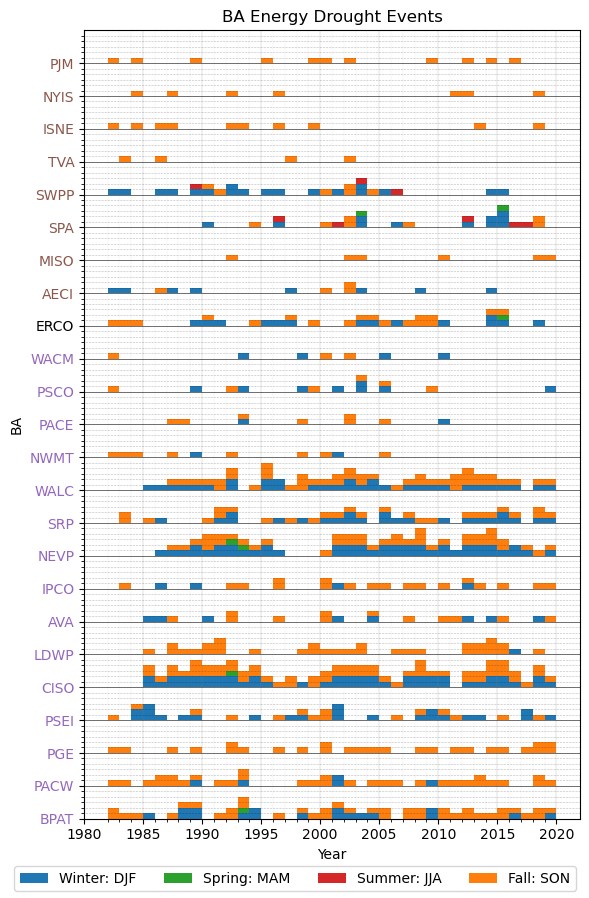

In [13]:
# set x locations (region) based on the maximum
binned_max = 6
y_locations = np.arange(0, np.max(binned_max) * len(col_sort), np.max(binned_max))

# plot
fig, ax = plt.subplots(figsize = (6, 9))
bins_year = np.arange(1982, 2020, bin_height)
for i, binned_data in enumerate(binned_dataset_winter):
    bottoms = y_locations[i]
    bar1 = ax.bar(bins_year + 0.5 * bin_height, binned_data, width = bin_height, bottom = bottoms, color = 'tab:blue', label = 'Winter')
for i, binned_data in enumerate(binned_dataset_spring):
    bottoms = y_locations[i] + binned_dataset_winter[i]
    bar2 = ax.bar(bins_year + 0.5 * bin_height, binned_data, width = bin_height, bottom = bottoms, color = 'tab:green', label = 'Spring')
for i, binned_data in enumerate(binned_dataset_summer):
    bottoms = y_locations[i] + binned_dataset_winter[i] + binned_dataset_spring[i]
    bar3 = ax.bar(bins_year + 0.5 * bin_height, binned_data, width = bin_height, bottom = bottoms, color = 'tab:red', label = 'Summer')
for i, binned_data in enumerate(binned_dataset_fall):
    bottoms = y_locations[i] + binned_dataset_winter[i] + binned_dataset_spring[i] + binned_dataset_summer[i]
    bar4 = ax.bar(bins_year + 0.5 * bin_height, binned_data, width = bin_height, bottom = bottoms, color = 'tab:orange', label = 'Fall')

ax.set_title(f'BA Energy Drought Events')#: {csv_drought}')
ax.set_xlim([1980, 2022])
ax.set_ylim([y_locations[0], y_locations[-1] + binned_max])
ax.set_yticks(y_locations, col_sort)
ax.set_xlabel('Year')
ax.set_ylabel('BA')
ax.set_xticks(bins_year, minor = True)
ax.set_yticks(np.arange(0, np.max(binned_max) * len(col_sort)), minor = True)
ax.xaxis.grid(True, 'major', color = 'gray', alpha = 0.8, linestyle = '-', linewidth = 0.2)
ax.xaxis.grid(True, 'minor', color = 'gray', alpha = 0.6, linestyle = ':', linewidth = 0.2)
ax.yaxis.grid(True, 'major', color = 'k', alpha = 1, linestyle = '-', linewidth = 0.4)
ax.yaxis.grid(True, 'minor', color = 'k', alpha = 0.5, linestyle = ':', linewidth = 0.4)
for ticklabel in ax.get_yticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
    
plt.subplots_adjust(bottom = 0.03)
plt.figlegend([bar1, bar2, bar3, bar4], ['Winter: DJF', 'Spring: MAM', 'Summer: JJA', 'Fall: SON'], loc = 'lower center', ncol = 4)
plt.tight_layout(rect = [0, 0.02, 1, 1])
plt.savefig('figures/FIGURE01.png', bbox_inches = 'tight', dpi = 300)
plt.show()